In [139]:
import pandas as pd
import numpy as np
import scipy
import itertools 
import seaborn as sns
from scipy.stats import norm
%matplotlib inline


In [65]:
df = pd.read_csv('./churn_analysis.csv')
df.loc[df.churn == 'False.', 'churn'] = 0
df.loc[df.churn == 'True.', 'churn'] = 1
df['churn'] = df.churn.astype(int)

In [3]:
# 1 

def chi2_state(df, state1, state2, correction):
    freq1 = df.loc[control.state==state1, 'churn'].value_counts()
    freq2 = df.loc[control.state==state2, 'churn'].value_counts()
    table = pd.concat([freq1, freq2], axis=1)
    table.fillna(0, inplace=True)
    chi2, pval, dof, exp = scipy.stats.chi2_contingency(table, correction=correction)
    return float(pval)

def fisher_state(df, state1, state2):
    freq1 = df.loc[control.state==state1, 'churn'].value_counts()
    freq2 = df.loc[control.state==state2, 'churn'].value_counts()
    table = pd.concat([freq1, freq2], axis=1)
    table.fillna(0, inplace=True)
    try:
        fisher, pval = scipy.stats.fisher_exact(table)
    except ValueError:
        print(table)
        raise SystemExit(0)
    return float(pval)


control = df[df.treatment == 1]
states_combinations = itertools.combinations(np.unique((control.state)), 2)

chi2 = []
chi2_corrected = []
fisher = []
for state1, state2 in states_combinations:
    chi2.append((state1, state2, chi2_state(control, state1, state2, False)))
    chi2_corrected.append((state1, state2, chi2_state(control, state1, state2, True)))
    fisher.append((state1, state2, fisher_state(control, state1, state2)))
    
pval_array = np.array(chi2)
pval_array_corrected = np.array(chi2_corrected)
pval_fisher = np.array(fisher)

In [4]:
np.sum(pval_array[:, 2].astype(float) < 0.05), \
np.sum(pval_array_corrected[:, 2].astype(float) < 0.05), \
np.sum(pval_fisher[:, 2].astype(float) < 0.05)

(34, 0, 10)

In [5]:
np.mean(pval_array[:, 2].astype(float)), \
np.mean(pval_array_corrected[:, 2].astype(float)), \
np.mean(pval_fisher[:, 2].astype(float))

(0.50182737987391579, 0.66405663820510474, 0.6483383060020681)

In [20]:
from scipy.stats.stats import pearsonr, spearmanr
from scipy.stats import shapiro
print(pearsonr(df.day_calls, df.mes_estim))
print(spearmanr(df.day_calls, df.mes_estim))
shapiro(df.day_calls)[1]

(-0.051794350587572625, 0.0027798836869756707)
SpearmanrResult(correlation=0.043349880533927444, pvalue=0.012317367189170541)


0.0002773392479866743

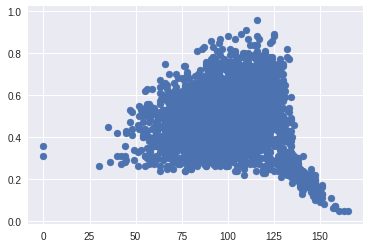

In [30]:
sns.plt.scatter(df.day_calls, df.mes_estim)

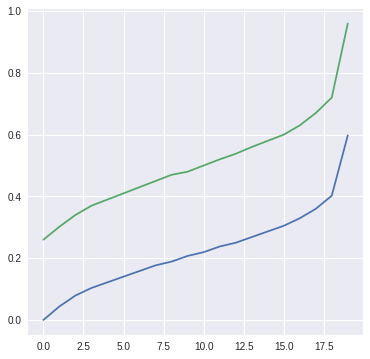

In [49]:
qq = []
qq2 = []
for q in np.linspace(0.05, 1, 20):
    qq.append(df.day_calls.quantile(q))
    qq2.append(df.mes_estim.quantile(q))

qq = np.array(qq)
qq = (qq-np.min(qq))/(np.max(qq)-np.min(q))

sns.plt.figure(figsize=(6,6))
sns.plt.plot(qq)
sns.plt.plot(qq2)

In [51]:
test1 = df[df.treatment == 0]
test2 = df[df.treatment == 2]


In [131]:
stat = df.groupby('treatment').churn.agg(['mean', 'count', 'std', sum])

,mean,count,std,sum
treatment,,,,
0,0.145631,1133,0.352892,165
1,0.164084,1097,0.370521,180
2,0.125113,1103,0.330997,138


In [86]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):       
    """ Confint difference of 2 binary independent samples """
    
    z = norm.ppf(1 - alpha / 2)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def get_bootstrap_samples(data, n_samples):
    """ bootstrap """
    
    data = np.array(data)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """ confint for bootstrap """
    
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [142]:
binom_control = [1] * stat['sum'][1] + [0] * (stat['count'][1]-stat['sum'][1])
binom_test1 = [1] * stat['sum'][0] + [0] * (stat['count'][0]-stat['sum'][0])
binom_test2 = [1] * stat['sum'][2] + [0] * (stat['count'][2]-stat['sum'][2])

proportions_confint_diff_ind(binom_control, binom_test1), \
proportions_confint_diff_ind(binom_control, binom_test2)

((-0.011583241590025106, 0.04848883584089464),
 (0.0096187667380921195, 0.068322308856685027))

In [90]:
test1_means = np.array(list(map(np.mean, get_bootstrap_samples(test1.churn, 1000))))
test2_means = np.array(list(map(np.mean, get_bootstrap_samples(test2.churn, 1000))))
control_means = np.array(list(map(np.mean, get_bootstrap_samples(control.churn, 1000))))

In [92]:
test1_means.mean(), test2_means.mean(), control_means.mean()


(0.14645542806707856, 0.1250815956482321, 0.1641659070191431)

In [97]:
shapiro(test1_means), shapiro(test2_means), shapiro(control_means)

((0.9985002279281616, 0.5547766089439392),
 (0.9974724650382996, 0.12409055233001709),
 (0.9982226490974426, 0.38867995142936707))

In [102]:
scipy.stats.ttest_ind(test1_means, test2_means), \
scipy.stats.ttest_ind(control_means, test1_means), \
scipy.stats.ttest_ind(control_means, test2_means)

(Ttest_indResult(statistic=46.413574933212423, pvalue=1.0634268961086991e-319),
 Ttest_indResult(statistic=35.940433602875345, pvalue=1.2824806616052743e-218),
 Ttest_indResult(statistic=82.731832563944124, pvalue=0.0))

In [130]:
table = pd.crosstab(control.state, control.churn)
chi2, pval, _ , _ = scipy.stats.chi2_contingency(table)
V = np.sqrt(chi2 / np.sum(table.sum()))
pval, V

(0.70975900427784733, 0.20039321502033319)